# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [17]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [18]:
# using SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [41]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

time_sorted_data=time_sorted_data[:40000]

x = time_sorted_data['CleanedText'].values

In [20]:
x.shape

(40000,)

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [21]:
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df = 1000) 
data = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text BOW vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (40000, 248)
the number of unique words : 248


In [22]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

# elbow method

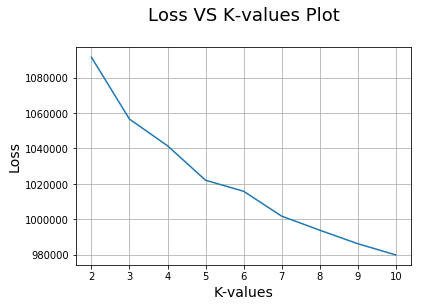

In [23]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

* OBSERVATION :- From above we can see that there is inflection at K =3. Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 3

In [24]:
optimal_k = 3
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

In [25]:
reviews = time_sorted_data['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))        

No. of reviews in Cluster-1 :  5539

No. of reviews in Cluster-2 :  33564

No. of reviews in Cluster-3 :  897


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [33]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])

Review-1 : 
 The wine saver is great in so many ways. Obviously it's wonderful to be able to open a bottle of wine and have it stay good for a day or two, especially if you just like one glass with dinner. This lets you open up and enjoy more expensive wine since you won't waste the whole rest of the bottle. If you are interested in learning about wines, you'll probably want to open up 2 or more wines at a time to compare them, and this way you won't waste anything. The wine saver will keep the undrunk portion until the next time.  I do recommend putting the bottle in the fridge if you don't drink it the next day. Just pull the bottle out an hour before you want to drink it if it's red.

Review-2 : 
 The spectra paste food colors are simply fantastic. They provide a depth and clarity of color that is impossible to achieve with liquid food colors. And the hues are beautiful and distinctive. The black and red, two colors which are very difficult to get when dying frostings, etc. are espe

### first cluster first review

* it takes lot of time to plot all reviews in a single cluster.so,i plotted 1st review of the the every cluster

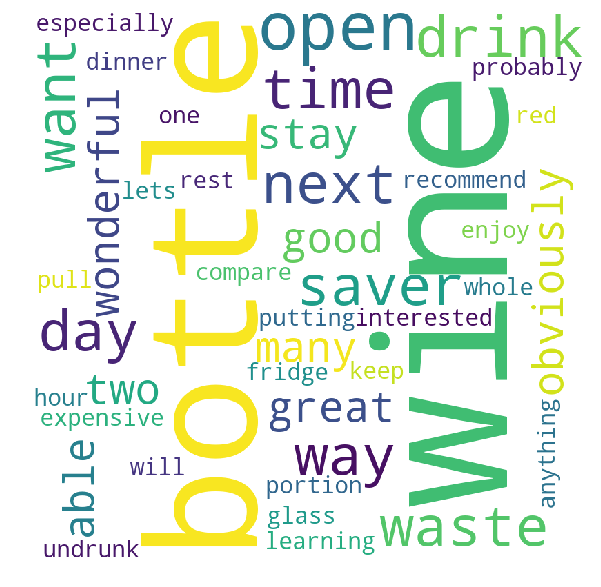

In [34]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### second cluster

In [36]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
m.append(cluster2[0])    

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



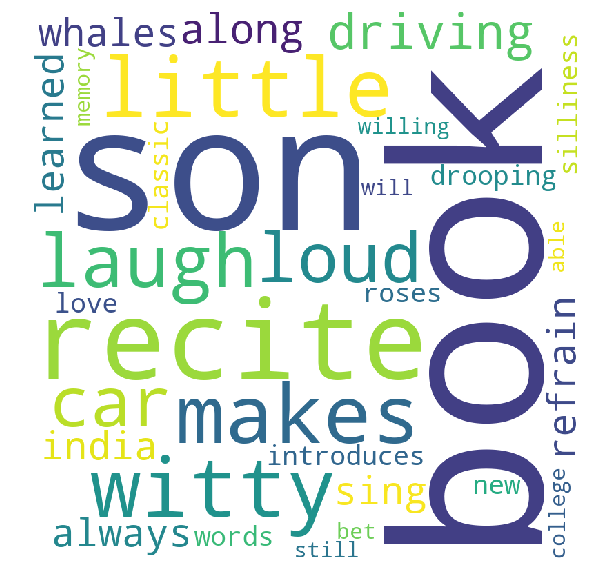

In [37]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [38]:
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
m.append(cluster3[0])    

Review-1 : 
 For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how long you steep it and if you add a sweetener of some f

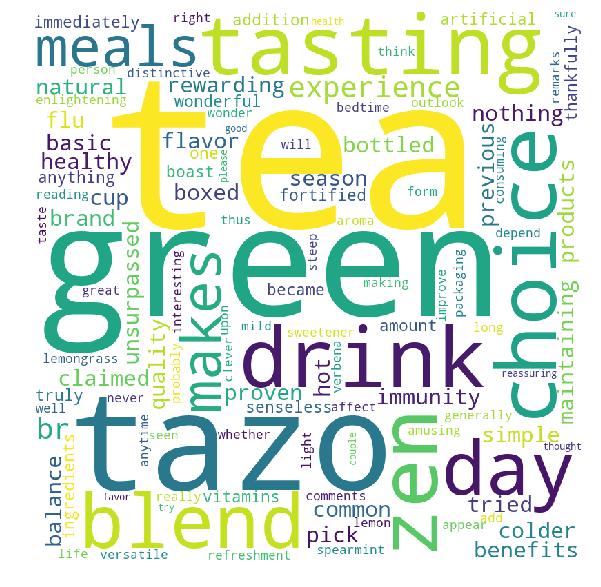

In [39]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [42]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=1000)
data = tf_idf_vect.fit_transform(x)
print("the type of count vectorizer :",type(data))
print("the shape of out text TFIDF vectorizer : ",data.get_shape())
print("the number of unique words :", data.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (40000, 248)
the number of unique words : 248


In [43]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

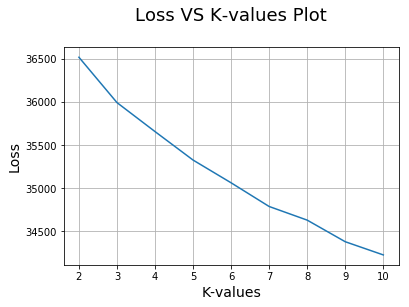

In [44]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

* OBSERVATION :- From above we can see that there is inflection at K =3. Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 3

In [45]:
optimal_k = 3
# Variable that will be used in the conclusion 
tfidf_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

In [46]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))        

No. of reviews in Cluster-1 :  3613

No. of reviews in Cluster-2 :  33827

No. of reviews in Cluster-3 :  2560


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])

Review-1 : 
 For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how long you steep it and if you add a sweetener of some f

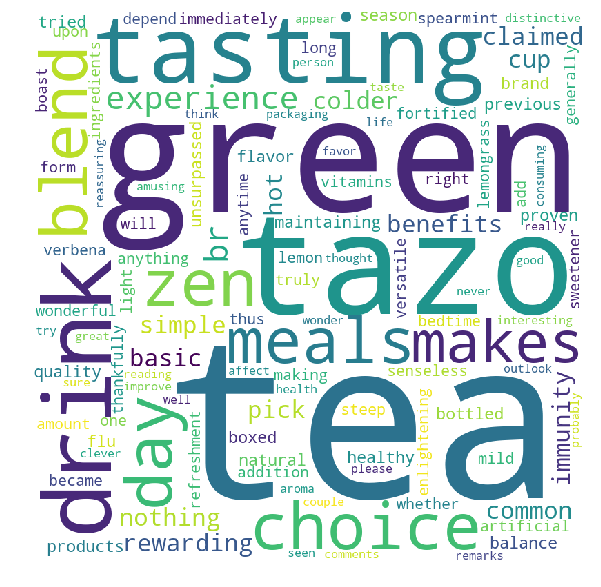

In [48]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [49]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
m.append(cluster2[0])    

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



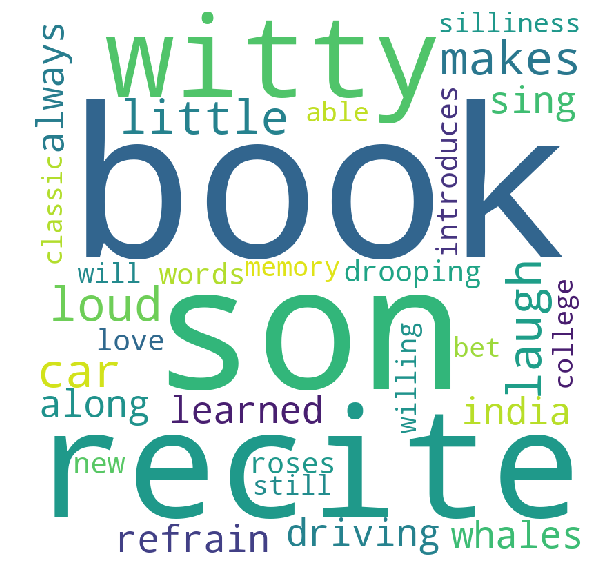

In [50]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [51]:
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
m.append(cluster3[0])    

Review-1 : 
 I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).

Review-2 : 
 After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck's Barista machine, and have found that the quality of the pod and the flavor of the espresso inside is, by far, the best in the Espressione pods. The flavor is more full bodied and stronger than in the Starbuck's pods. I actually use one pod to make two shots of espresso, and the flavor is more intense than when I buy my specialty drinks from Starbucks or other coffee houses.<p>Also, the pod itself is of very high quality. Each pod is individually wrapped in an airtight, hard foil wrapper, and I've never opened a package yet that contained a to

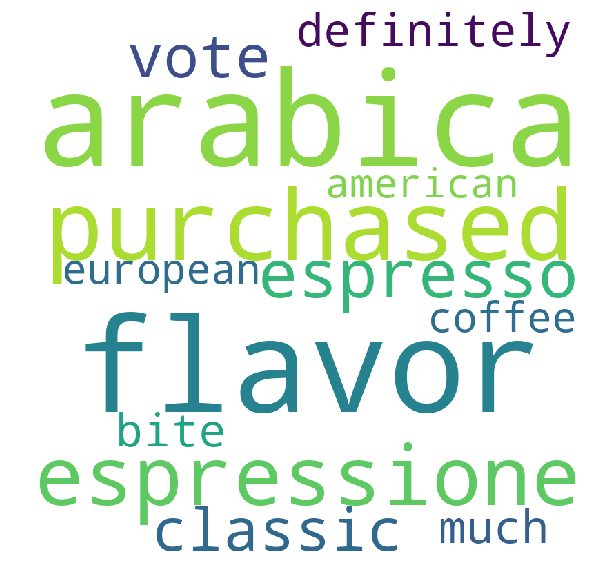

In [52]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [53]:
# Please write all the code with proper documentation
# List of sentence in X_train text
sent_x = []
for sent in x :
    sent_x.append(sent.split())
  
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_x,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  8418


In [54]:
# compute average word2vec for each review for sent_x .
train_vectors = []; 
for sent in sent_x:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
data = train_vectors    

In [55]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

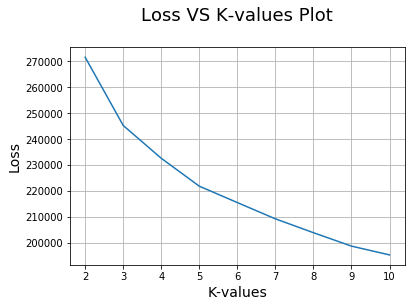

In [56]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [57]:
optimal_k = 3
# Variable that will be used in the conclusion 
avg_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))

No. of reviews in Cluster-1 :  6593

No. of reviews in Cluster-2 :  14925

No. of reviews in Cluster-3 :  18482


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [58]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

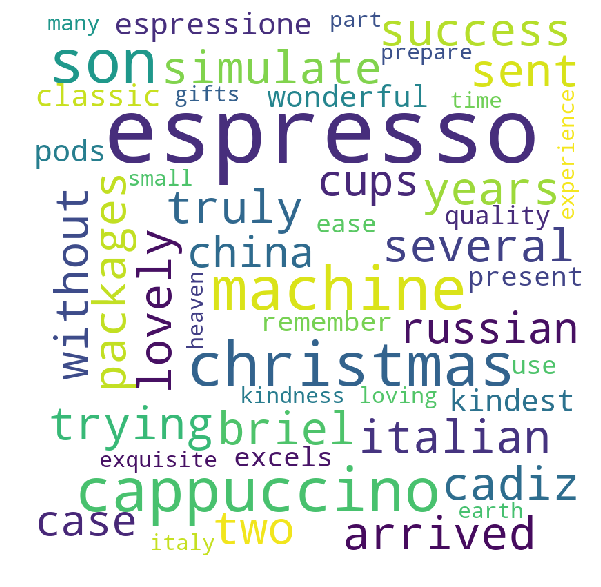

In [59]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [60]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

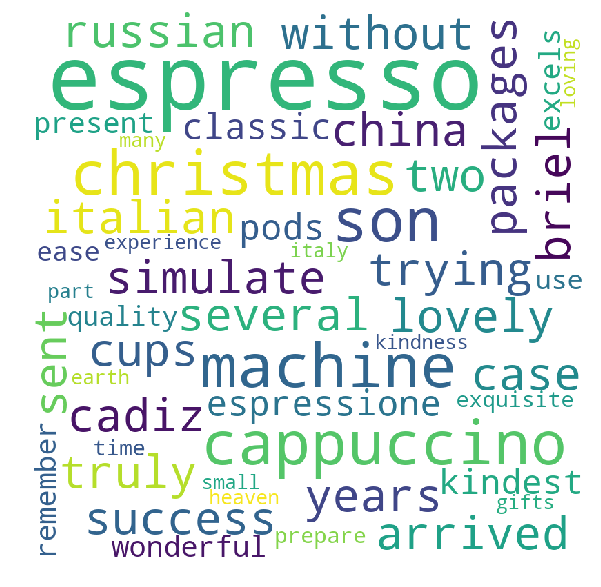

In [61]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [62]:
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        count +=1
m.append(cluster3[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

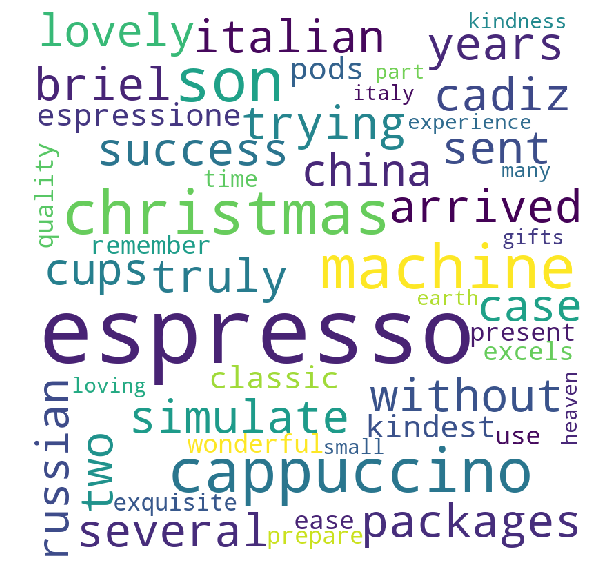

In [63]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [64]:
# Please write all the code with proper documentation
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for sent_x .
tfidf_vectors = []; 
row=0;
for sent in sent_x: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
data = tfidf_vectors    

In [65]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(data)
    loss.append(kmeans.inertia_)

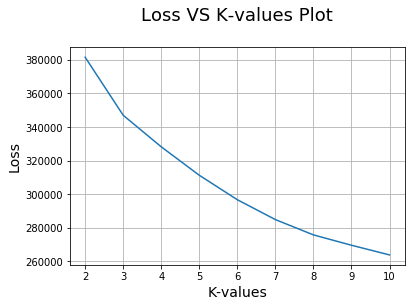

In [66]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

* OBSERVATION :- From above we can see that there is inflection at K = 3 . Befor it loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 3.

In [67]:
optimal_k = 3
# Variable that will be used in the conclusion 
tfidf_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))

No. of reviews in Cluster-1 :  5682

No. of reviews in Cluster-2 :  18145

No. of reviews in Cluster-3 :  16173


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [68]:
# Please write all the code with proper documentation
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

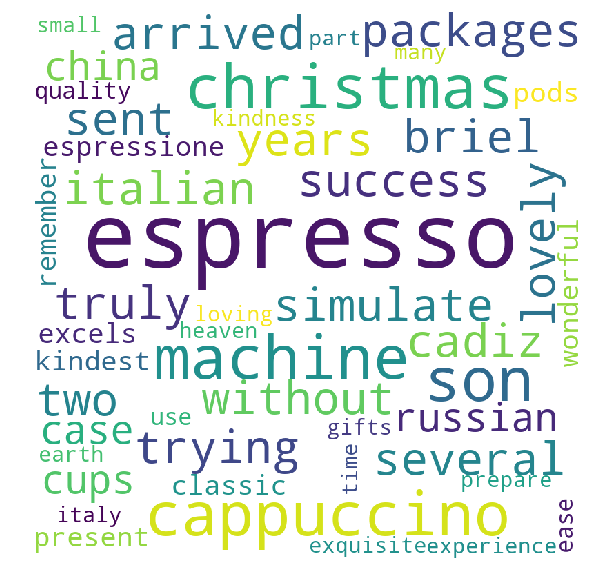

In [69]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [70]:
# Please write all the code with proper documentation
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

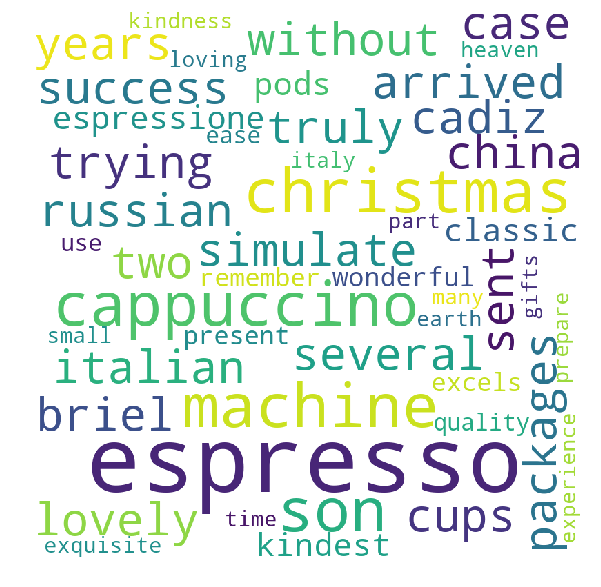

In [71]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [72]:
# Please write all the code with proper documentation
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        count +=1
m.append(cluster3[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

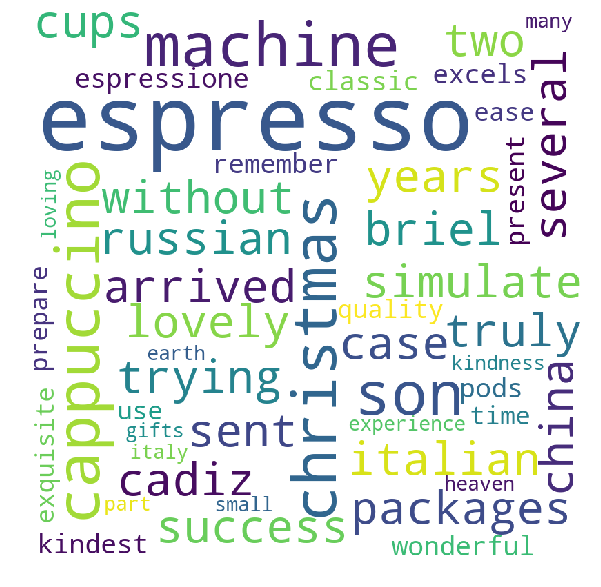

In [73]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## [5.2] Agglomerative Clustering

In [77]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 4K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data[:4000]

x = my_final['CleanedText'].values

In [78]:
x.shape

(4000,)

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [122]:
# Please write all the code with proper documentation
# List of sentence in X_train text
sent_x = []
for sent in x :
    sent_x.append(sent.split())
  
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_x,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  3498


In [123]:
# compute average word2vec for each review for sent_x .
train_vectors = []; 
for sent in sent_x:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
data = train_vectors  

In [124]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2).fit(data)

reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  2406

No. of reviews in Cluster-2 :  1594


In [125]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
m.append(cluster1[0])    

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



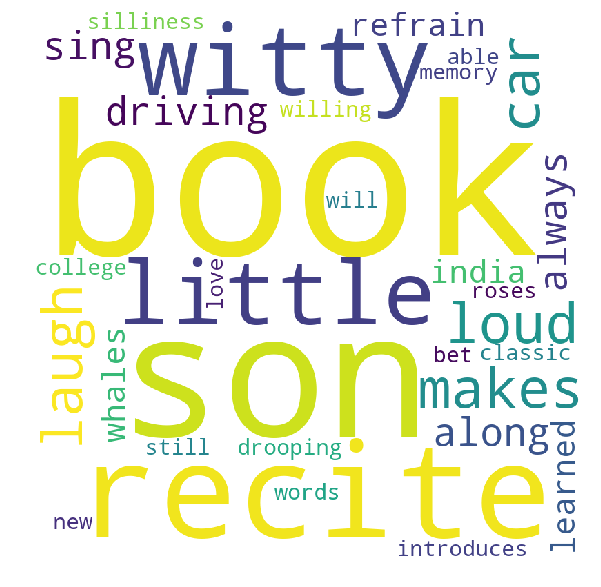

In [126]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [127]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])

Review-1 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-2 : 
 I'm sick of scads of nasty toothpicks all over my counter when I'm tinting icings;  the squeeze-bottle concept is one that is long overdue and exceptionally welcome.  The colors are vibrant, do not have an offensive taste, and blend, in my opinion, more smoothly than the Wilton pastes.  You'll need to experiment a bit to get hues right at first, but it's well worth it.

Review-3 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in qual

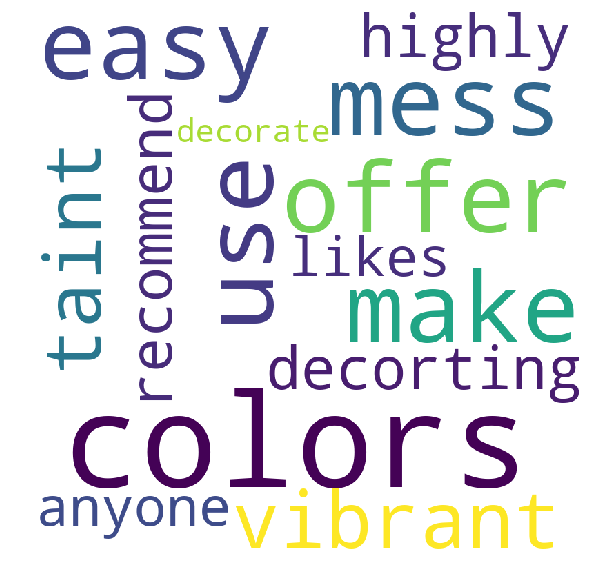

In [128]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Hierarchical Clustering with 5 clusters

In [129]:
model = AgglomerativeClustering(n_clusters=5).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5)) 

No. of reviews in Cluster-1 :  1342

No. of reviews in Cluster-2 :  930

No. of reviews in Cluster-3 :  134

No. of reviews in Cluster-4 :  521

No. of reviews in Cluster-5 :  1073


In [130]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.

Review-3 : 
 A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime.  Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull  moment.



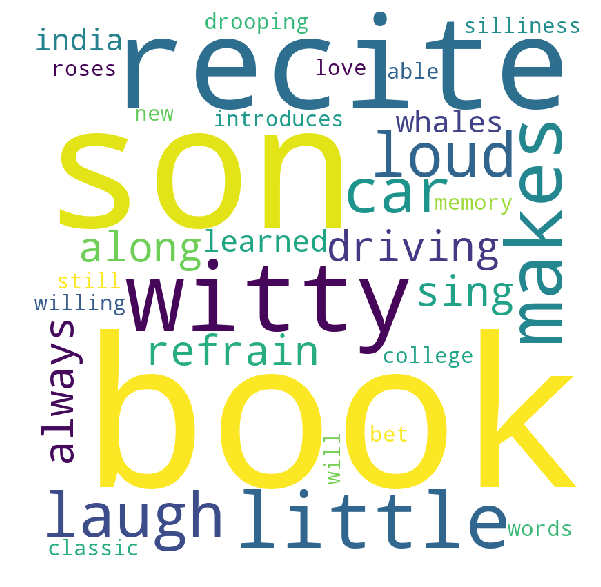

In [131]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [132]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])

Review-1 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-2 : 
 I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.

Review-3 : 
 What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple

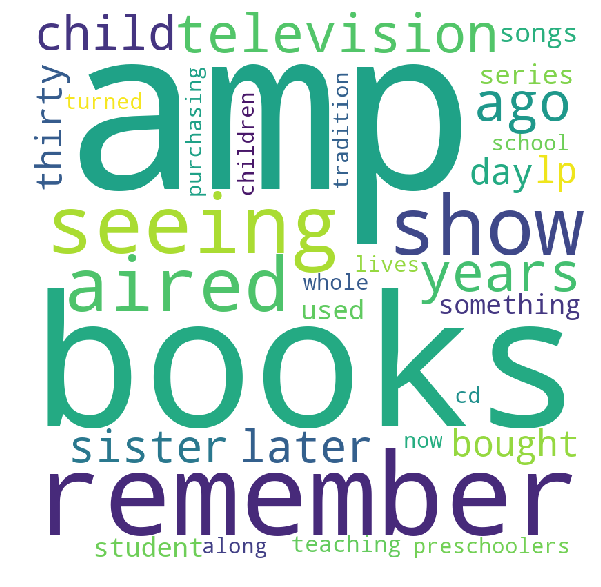

In [133]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [134]:
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        count +=1
m.append(cluster3[0])

Review-1 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.

Review-2 : 
 After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck'

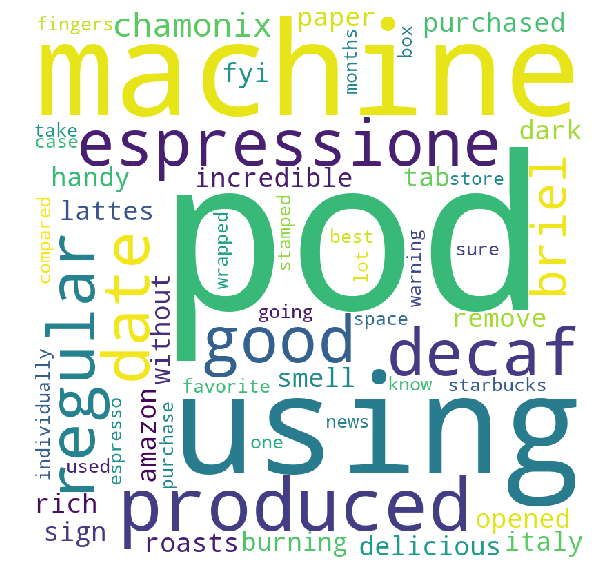

In [135]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [136]:
# Three Reviews of cluster 4
count=1
m=[]
for i in range(3):
    if i < len(cluster4):
        print('Review-%d : \n %s\n'%(count,cluster4[i]))
        count +=1
m.append(cluster4[0])

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).

Review-3 : 
 For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for main

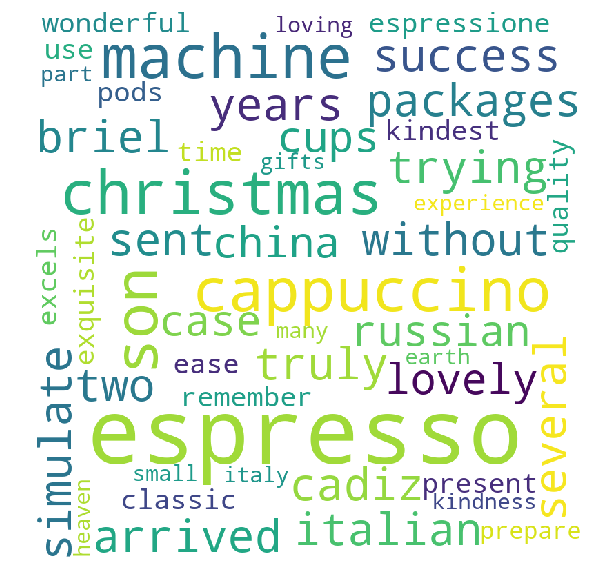

In [137]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [138]:
# Three Reviews of cluster 5
count=1
m=[]
for i in range(3):
    if i < len(cluster5):
        print('Review-%d : \n %s\n'%(count,cluster5[i]))
        count +=1
m.append(cluster5[0])

Review-1 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-2 : 
 I'm sick of scads of nasty toothpicks all over my counter when I'm tinting icings;  the squeeze-bottle concept is one that is long overdue and exceptionally welcome.  The colors are vibrant, do not have an offensive taste, and blend, in my opinion, more smoothly than the Wilton pastes.  You'll need to experiment a bit to get hues right at first, but it's well worth it.

Review-3 : 
 Fresh limes are underappreciated, but a joy to have in the kitchen.  A few squirts of lime juice into water makes a wonderful and healthy alternative to carbonated beverages (and without sugar!). <p>Additionally, they're essential for doing salsa right.  <p>1/4 C Lime juice (from 4 limes)<br />10 small tomatillos, husks removed and washed (ASIN B0000TL6DG)<br />2-3 Chipotles, seeds r

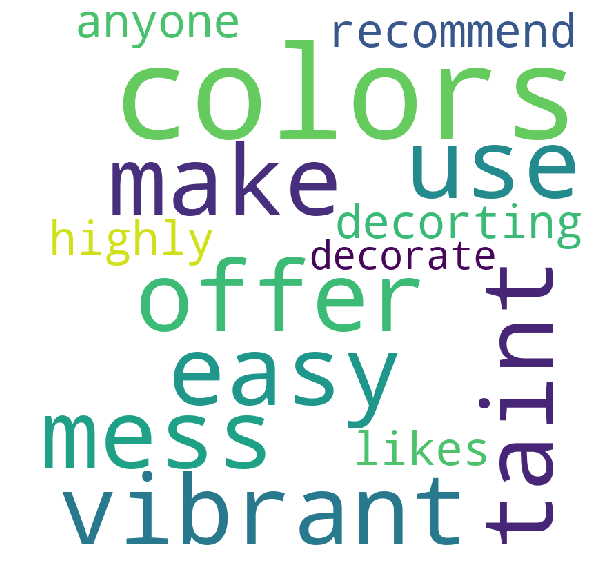

In [139]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Hierarchical Clustering with 10 clusters

In [99]:
model = AgglomerativeClustering(n_clusters=10).fit(data)
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []
cluster10 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif model.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif model.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif model.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif model.labels_[i] == 7:
        cluster8.append(reviews[i])
    elif model.labels_[i] == 8:
        cluster9.append(reviews[i])       
    else :
        cluster10.append(reviews[i]) 

In [100]:
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5)) 
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))
print("\nNo. of reviews in Cluster-10 : ",len(cluster10)) 

No. of reviews in Cluster-1 :  540

No. of reviews in Cluster-2 :  729

No. of reviews in Cluster-3 :  182

No. of reviews in Cluster-4 :  701

No. of reviews in Cluster-5 :  647

No. of reviews in Cluster-6 :  217

No. of reviews in Cluster-7 :  230

No. of reviews in Cluster-8 :  64

No. of reviews in Cluster-9 :  559

No. of reviews in Cluster-10 :  131


In [102]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])        

Review-1 : 
 As a kid this ice cream was a favorite treat.  I've been told it has the highest milk fat content of any ice cream around and man can you taste it. This stuff is amazing. If you are a fan of premium ice cream this is the best stuff.

Review-2 : 
 I just love this sauce. I put in on everything.

Review-3 : 
 A piquant, sweet, colorful treat.  Don't be put off by the Hot designation - no hotter than a pepperoncini.  Really great for adding a little color and sweetness to lots of dishes



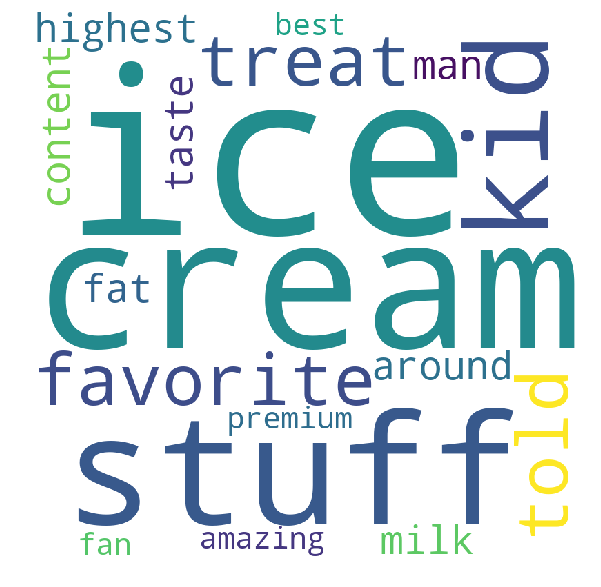

In [103]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [104]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])        

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



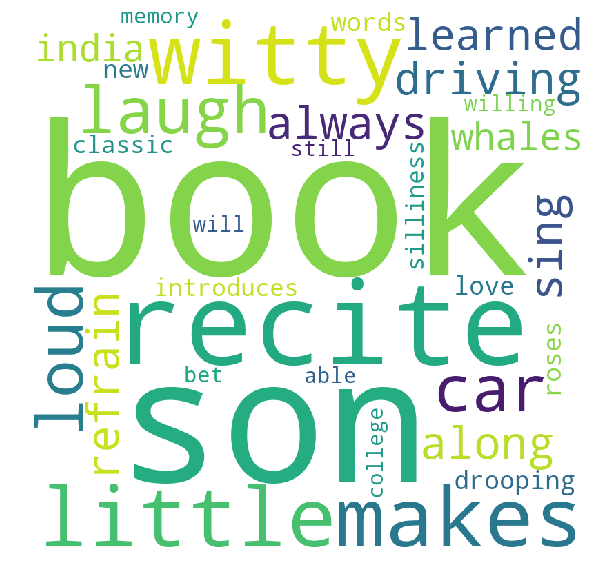

In [105]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [106]:
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        count +=1
m.append(cluster3[0])        

Review-1 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.

Review-2 : 
 After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck'

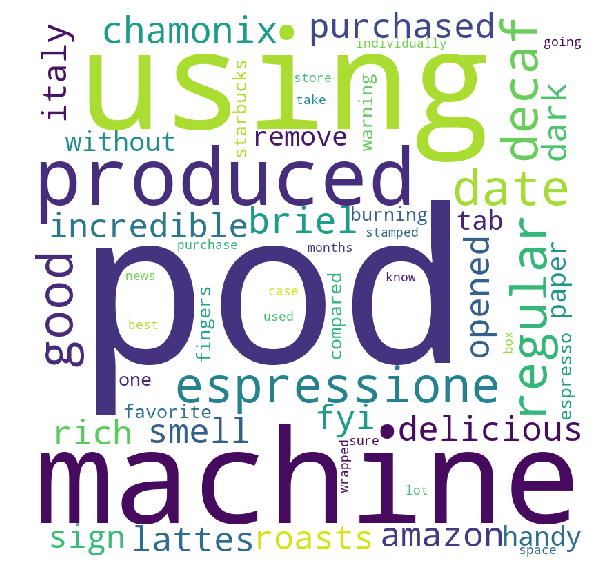

In [107]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [108]:
# Three Reviews of cluster 4
count=1
m=[]
for i in range(3):
    if i < len(cluster4):
        print('Review-%d : \n %s\n'%(count,cluster4[i]))
        count +=1
m.append(cluster4[0])        

Review-1 : 
 This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!

Review-2 : 
 I don't know why anyone would ever use those little liquid food colors again after trying these pastes. The colors are more intense, and you can easily blend lovely shades for your icings. <p>Martha Stewart shows wonderful seasonal cookies from time to time on her TV show. A simple eggwhite-sugar icing on cookies in exciting colors makes such a wonderful table decoration as well as great dessert for parties, teas and other events. These paste colors are a must if you like to make frosted cookies or party cakes. <p>And these are especially fun if you have kids. A cookie-icing contest is a fun event for a birthday party, Christmas party or just a rainy afternoon.

Review-3 : 


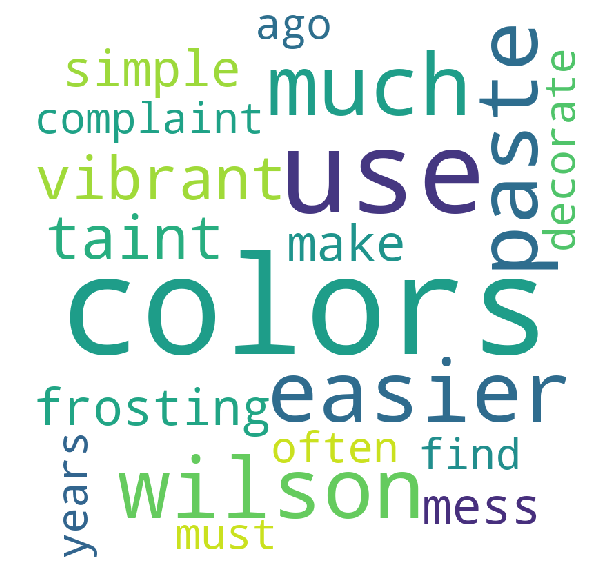

In [109]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [110]:
# Three Reviews of cluster 5
count=1
m=[]
for i in range(3):
    if i < len(cluster5):
        print('Review-%d : \n %s\n'%(count,cluster5[i]))
        count +=1
m.append(cluster6[0])        

Review-1 : 
 I'm getting crazy.<p>Is it really impossible today not to find the French VHS version of this film ?<p>Could U please tell me something about it ? Tks

Review-2 : 
 This was a favorite book of mine when I was a little girl and I would read it all the time and my Mom would read it to me as a bedtime book, I have had two copies of this book the first one had been either lost or given away but I found another copy at a garage sale and it was in very good condition and I just had to buy it, I don't know where it is but it's around somewhere probably up in the attic and I will have to look for it so I can read it to my niece. I recommend this book!

Review-3 : 
 Although this was a gift to use for keeping wine, I have also found it invaluable for keeping olive oils and other items fresh for longer periods.  It is easy to use and easy to store.



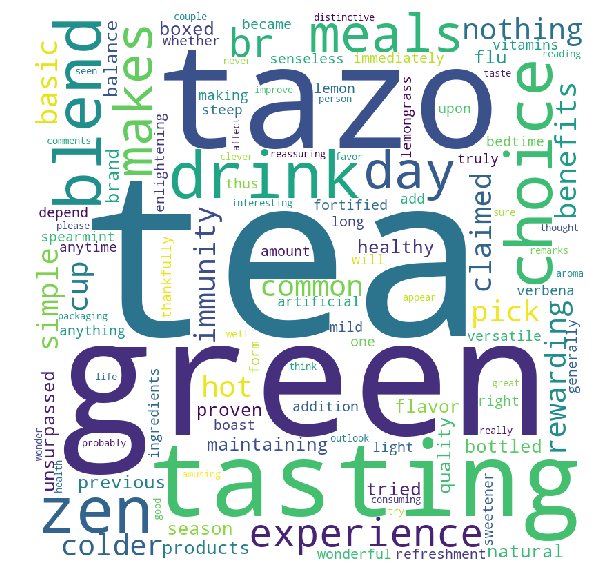

In [111]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [112]:
# Three Reviews of cluster 6
count=1
m=[]
for i in range(3):
    if i < len(cluster6):
        print('Review-%d : \n %s\n'%(count,cluster6[i]))
        count +=1
m.append(cluster6[0])        

Review-1 : 
 For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how long you steep it and if you add a sweetener of some f

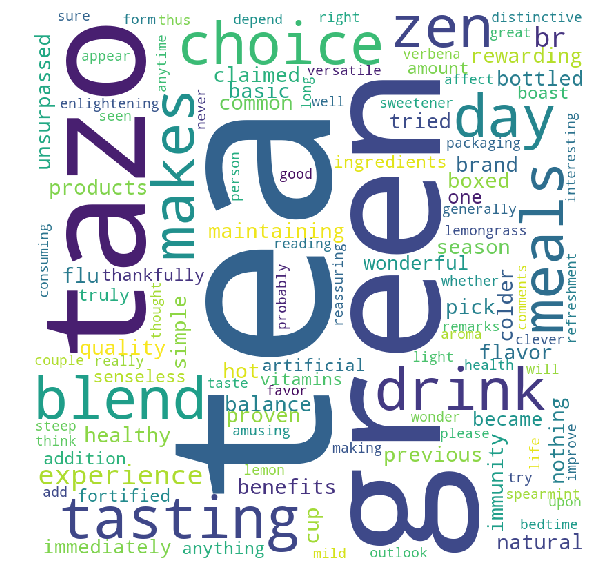

In [113]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [114]:
# Three Reviews of cluster 7
count=1
m=[]
for i in range(3):
    if i < len(cluster7):
        print('Review-%d : \n %s\n'%(count,cluster7[i]))
        count +=1
m.append(cluster7[0])        

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).

Review-3 : 
 Few things I'd like to point out:<p>1.  &quot;Espresso&quot; is not a roast.  It's a drink.  In northern Italy they make espresso from Vienna roast, in southern Italy t

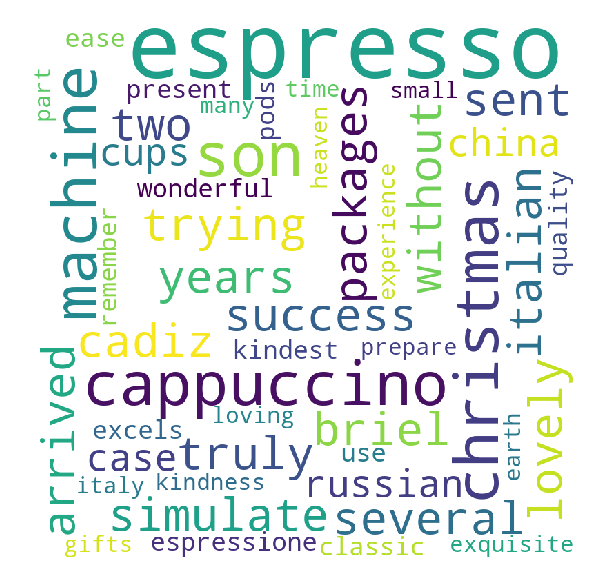

In [115]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [116]:
# Three Reviews of cluster 8
count=1
m=[]
for i in range(3):
    if i < len(cluster8):
        print('Review-%d : \n %s\n'%(count,cluster8[i]))
        count +=1
m.append(cluster8[0])        

Review-1 : 
 love the snack.  wanted to buy a bunch.<p>shipping at amazon is more than the price of the snack.  try ordering a dozen and then look at the shipping price.<p>every link i've tried to this snack takes you back to amazon's exhorbitant shipping rates.<p>another reason to buy your books at overstock.com.  too back they don't carry food as well.

Review-2 : 
 I think it is Very Expensive  !!<br />I can get it at local Indian or Chinese store for $20 in California.

Review-3 : 
 Just got my parm and WOW! SO much better than what you can get in the store here. I can see how this will go fast. I will buy from these guys again.



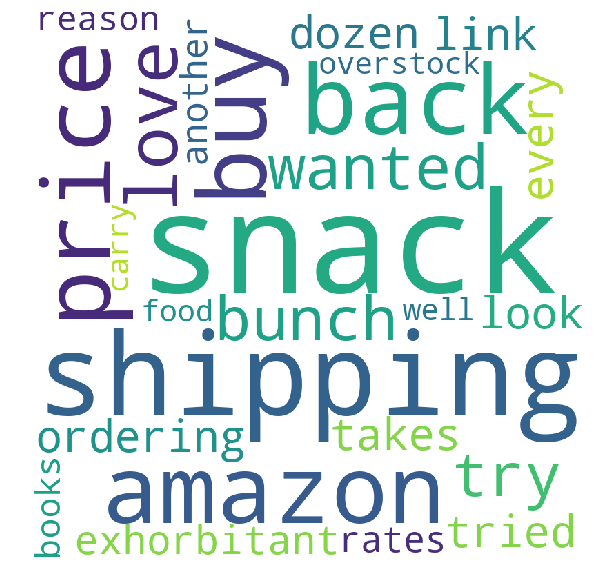

In [117]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [118]:
# Three Reviews of cluster 9
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster9[i]))
        count +=1
m.append(cluster9[0])        

Review-1 : 
 Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice!

Review-2 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-3 : 
 This is such a great film, I don't even know how to sum it up. First of  all, it is completely original and it is unlike any film I have ever seen  before. Second of all, it's a great comedy with kind of a spooky, weird  feel to it, which is something all of Tim Burton's films have. The look of  the film is probably what I like the best. Art Director Bo Welch and Tim  Burton show us a world unlike anything seen in a movie.  This is a great  film, and I would recommend it to anyone looking for an enjoyable,  

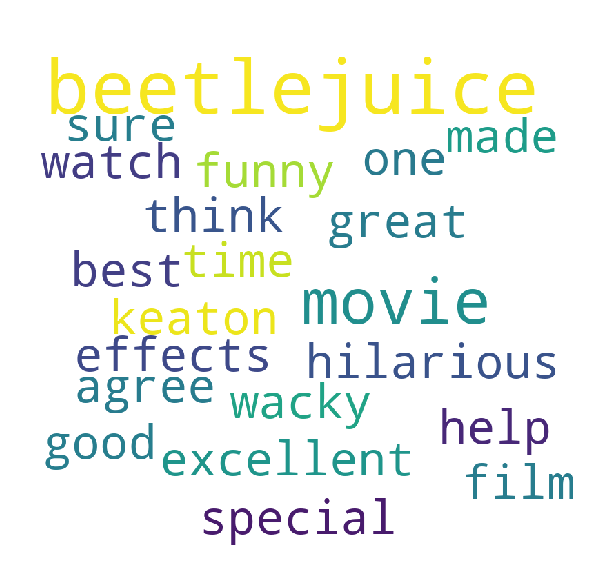

In [119]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [120]:
# Three Reviews of cluster 10
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster10[i]))
        count +=1
m.append(cluster10[0])        

Review-1 : 
 Winona Ryder is HOT! HOT! HOT! as the gothic death-rock princess of Doom (see &quot;Lucas&quot; for more W.R. action) The best performance from that eldest Baldwin brother that I've ever seen from any of them.His zenith I'm sure. BEST PERFORMANCE - goes to - Miss Ryder!,of course, I'm a BIG fan, you see? FAV PART - when Beetlejuice was chumming up to Baldwin's character while wearing the same type clothes. No big deal, just witty and clever charm with spit. and when Beetlejuice hits up on Gina Davis and/or Winona Ryder

Review-2 : 
 Embarrassing comedy that comes over like a child with 'attention deficit disorder' begging for your approval. Even the film's own internal logic is thrown away towards the end to no extra purpose. The girl floating in the air at the end is rather sweet though.

Review-3 : 
 Fresh limes are underappreciated, but a joy to have in the kitchen.  A few squirts of lime juice into water makes a wonderful and healthy alternative to carbonated beverages

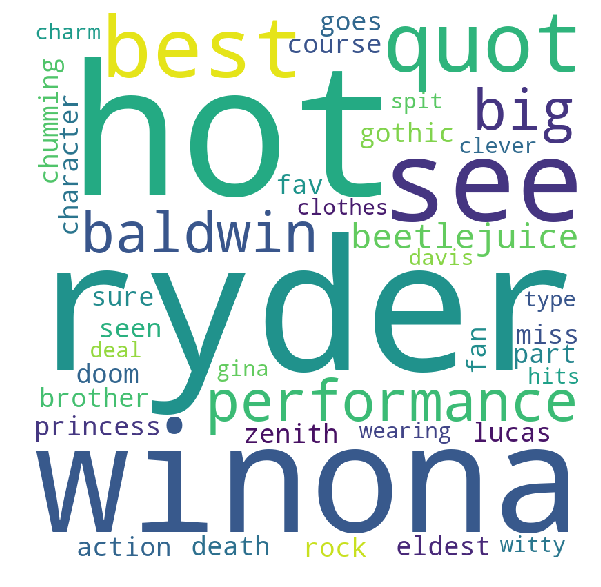

In [121]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [140]:
# Please write all the code with proper documentation
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for sent_x .
tfidf_vectors = []; 
row=0;
for sent in sent_x: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
data = tfidf_vectors  

In [141]:
model = AgglomerativeClustering(n_clusters=2).fit(data)

reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  2156

No. of reviews in Cluster-2 :  1844


In [142]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])

Review-1 : 
 This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!

Review-2 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-3 : 
 This is such a great film, I don't even know how to sum it up. First of  all, it is completely original and it is unlike any film I have ever seen  before. Second of all, it's a great comedy with kind of a spooky, weird  feel to it, which is something all of Tim Burton's films have. The look of  the film is probably what I like the best. Art Director Bo Welch and Tim  Burton show us a world unlike anything seen in a movie.  This is a great  film, and I would recom

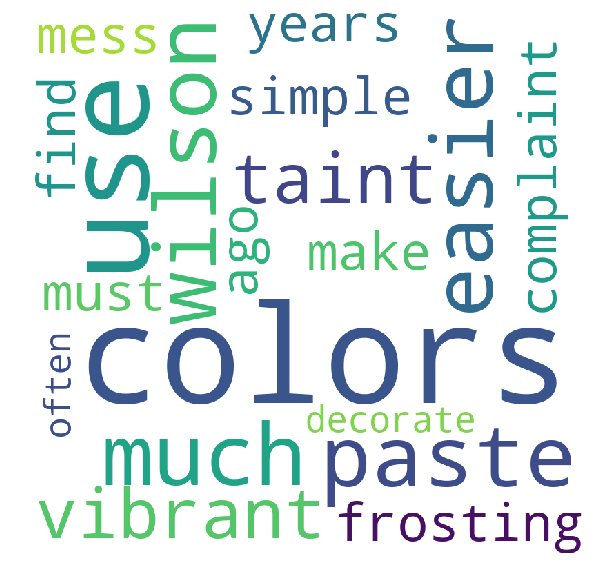

In [143]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [145]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



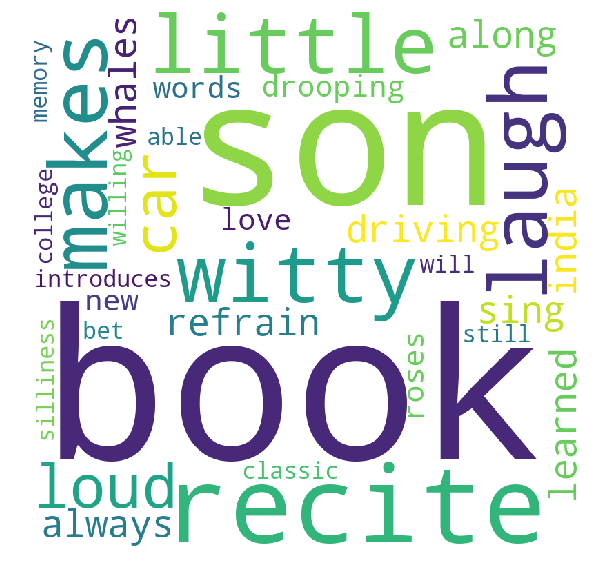

In [146]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Hierarchical Clustering with 5 clusters

In [147]:
model = AgglomerativeClustering(n_clusters=5).fit(data)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5)) 

No. of reviews in Cluster-1 :  1608

No. of reviews in Cluster-2 :  1100

No. of reviews in Cluster-3 :  276

No. of reviews in Cluster-4 :  272

No. of reviews in Cluster-5 :  744


In [148]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])        

Review-1 : 
 This are so much easier to use than the Wilson paste colors.  Colors are  vibrant, and do not taint the frosting like some colors can.  These are  simple to use, and do not make a mess.  My only complaint is that I did not  find these years ago.  This is a must have if you decorate often!

Review-2 : 
 These are easy to use, they do not make a mess, and offer vibrant colors.  They do not taint what you are decorting as some colors can.  I would  highly recommend these to anyone to likes to decorate.

Review-3 : 
 This is such a great film, I don't even know how to sum it up. First of  all, it is completely original and it is unlike any film I have ever seen  before. Second of all, it's a great comedy with kind of a spooky, weird  feel to it, which is something all of Tim Burton's films have. The look of  the film is probably what I like the best. Art Director Bo Welch and Tim  Burton show us a world unlike anything seen in a movie.  This is a great  film, and I would recom

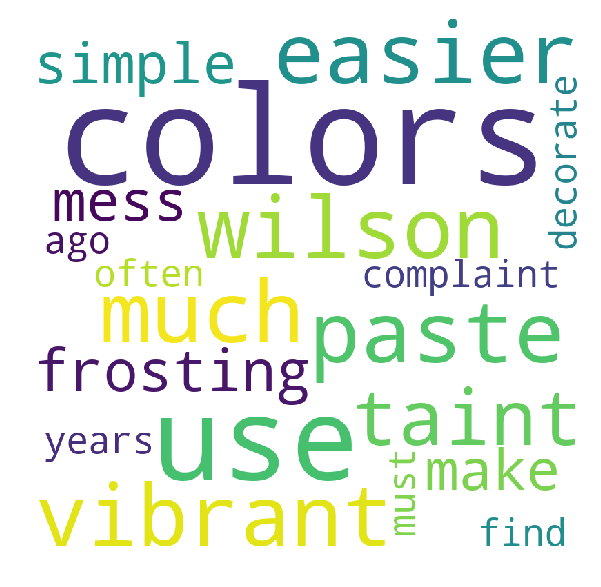

In [149]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [151]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])        

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



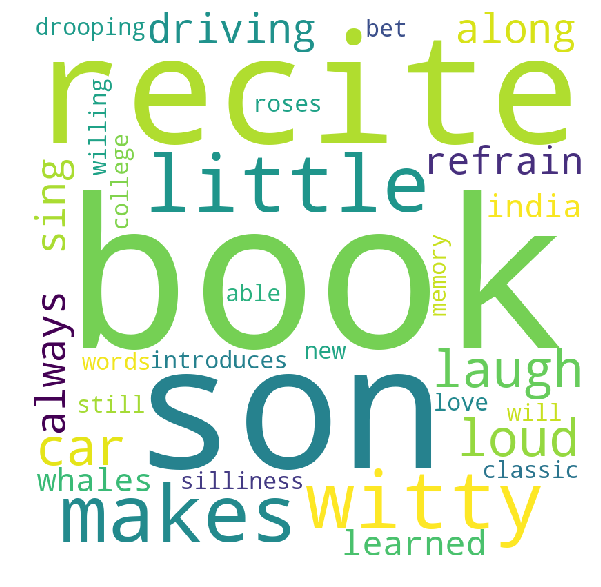

In [152]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [153]:
# Three Reviews of cluster 3
count=1
m=[]
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        count +=1
m.append(cluster3[0])        

Review-1 : 
 For years I have been trying to simulate a truly Italian espresso or cappuccino without success.  Several packages arrived [...] just before Christmas.  My son had sent a Briel Cadiz Espresso machine, two lovely Russian china cups and a case of Espressione Classic Espresso Pods.  It was the kindest, most wonderful Christmas present I can remember.  The espresso machine excels in quality and ease of use.  The espresso is exquisite.  Each time I prepare an espresso or cappuccino I experience my son's loving kindness and a small part of the many gifts of Italy.  Heaven on Earth.

Review-2 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I co

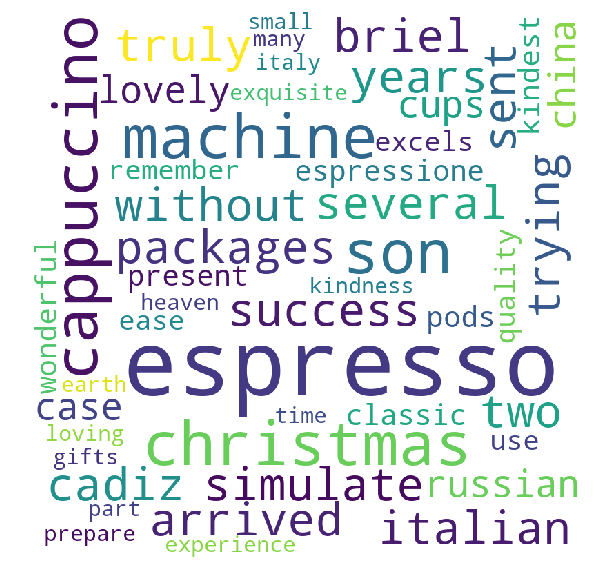

In [154]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [155]:
# Three Reviews of cluster 4
count=1
m=[]
for i in range(3):
    if i < len(cluster4):
        print('Review-%d : \n %s\n'%(count,cluster4[i]))
        count +=1
m.append(cluster4[0])        

Review-1 : 
 For me, when the days get colder nothing is as rewarding as a simple cup of hot tea. And for it's claimed immunity benefits, a basic green tea is a common pick for maintaining a healthy natural balance during the flu season. From previous experiences in tasting the Tazo brand, both of the bottled and boxed products, they have proven to be unsurpassed for quality and flavor. Once I've tried their teas they immediately became my drink of choice. <p>The Zen Green Tea Blend is a wonderful one that has only a few ingredients with no artificial anything. And thankfully, doesn't boast the addition of fortified vitamins in some senseless amount. It truly is an enlightening blend of green tea, spearmint, lemongrass and lemon verbena. Thus making it versatile refreshment for anytime of the day, whether it's right after meals or between meals, or just before bedtime. Generally light and mild tasting, but that will depend upon how long you steep it and if you add a sweetener of some f

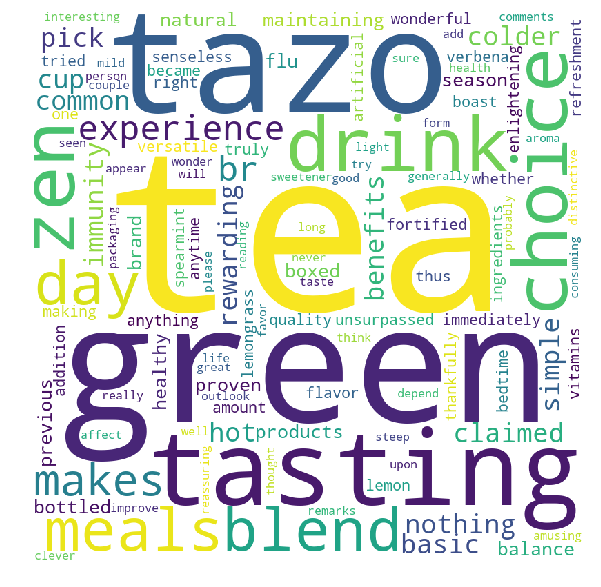

In [156]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [158]:
# Three Reviews of cluster 5
count=1
m=[]
for i in range(3):
    if i < len(cluster5):
        print('Review-%d : \n %s\n'%(count,cluster5[i]))
        count +=1
m.append(cluster5[0])        

Review-1 : 
 Beetlejuice is an excellent and funny movie. Keaton is hilarious as the wacky beetlejuice. The great special effects help the film. I think this is one of the best movies ever made and I'm sure you'll agree. For a good  time, watch beetlejuice!

Review-2 : 
 What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get 

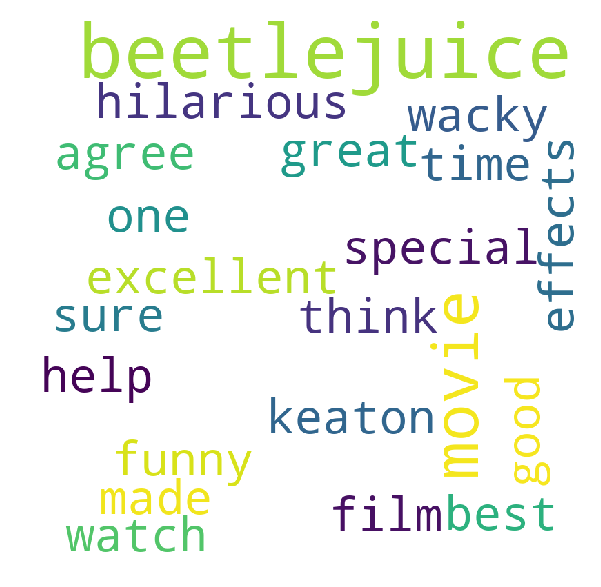

In [159]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [160]:
# Please write all the code with proper documentation
# List of sentence in X_train text
sent_x = []
for sent in x :
    sent_x.append(sent.split())
  
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_x,min_count=5,size=100, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  3498


In [164]:
# compute average word2vec for each review for sent_x .
from sklearn.preprocessing import StandardScaler
train_vectors = []; 
for sent in sent_x:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
#Standardising the data
data = StandardScaler().fit_transform(train_vectors)

* ELBOW METHOD TO FIND RIGHT EPSILON :

In [166]:
# function to determinethe distance of nth-nearest neighbour to all points in a multi-dimensional array
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))    

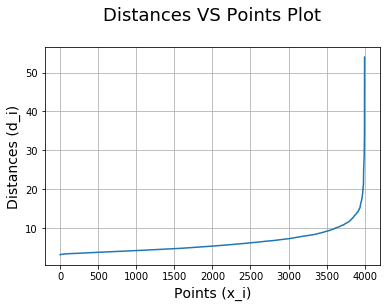

In [167]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

* OBSERVATION :- From above we can see that the right value of Epsilon is 10 because after that there is sharp rise in the value of distances (d_i's)

# dbscan

In [171]:
# Function definition for implementing DBSCAN
from sklearn.cluster import DBSCAN

def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

In [172]:
optimal_eps = 10
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 11
db2 = dbscan(11, min_points, data)


# Clustering with epsilon = 12
db3 = dbscan(12, min_points, data)


# Clustering with epsilon = 13
db4 = dbscan(13, min_points, data)

Number of clusters for MinPts = 200 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 11.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 12.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 13.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [176]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=10, min_samples=min_points, n_jobs=-1).fit(data)

reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  3954

No. of reviews in Cluster-2 :  46


In [177]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])        

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



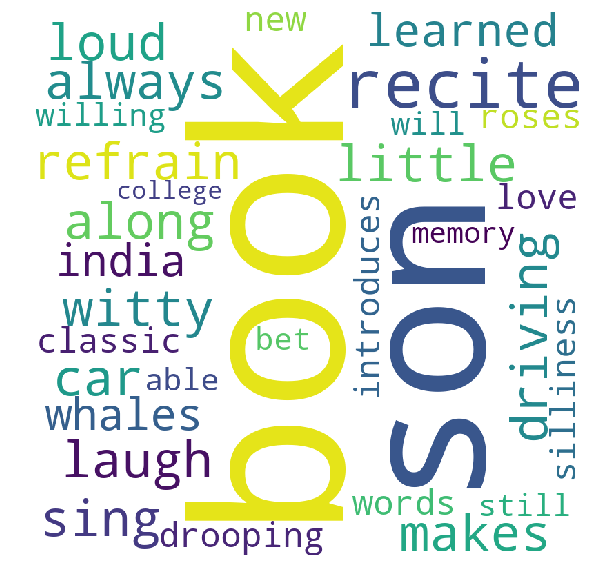

In [178]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [179]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])        

Review-1 : 
 Starbucks coffee is in my opinon second to none. Best coffee I have ever had.

Review-2 : 
 La bourbena e autunno in australia foglio dimmi dimmi dimi, voglio supre dutto dimme non mi pice la turbon, mi pice la bourbon, le occhi azzuri, e gli nuvoloso e rosso e tu?<p>P.S. All hail the mightly .... SAFRA BOURBON!!!!!!!

Review-3 : 
 The Dark Roast is the best of the coffee pods available for the Senseo Coffee Machine.  Full body coffee and as with all the coffee made with the Senseo Coffee Machine, never burnt.  Fantastic!



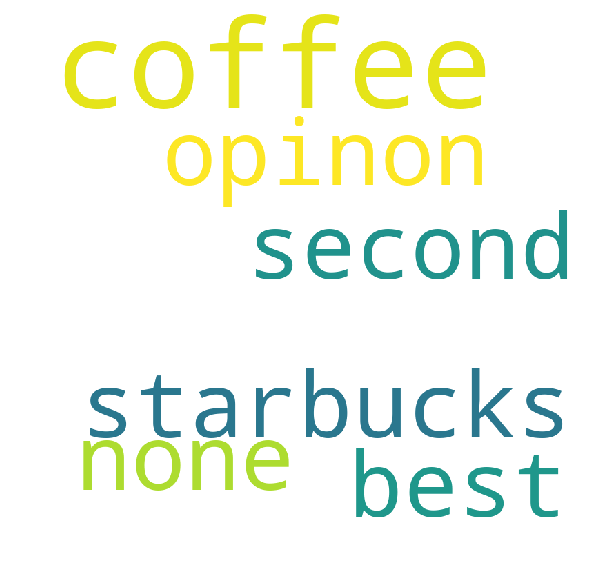

In [180]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Visualizing The Clusters :

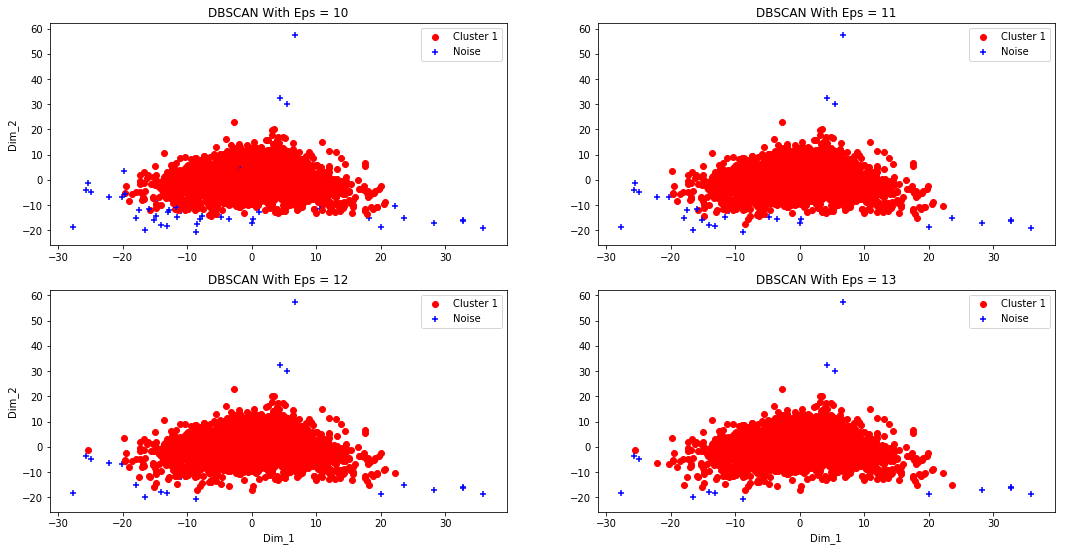

In [175]:
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 10
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 10')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 11
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 11')

# Scatter plot for DBSCAN with Eps = 12
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 12')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 13
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1,c2], ['Cluster 1','Noise'])  
plt.title('DBSCAN With Eps = 13')
plt.xlabel('Dim_1')

plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [182]:
# Please write all the code with proper documentation
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for sent_x .
tfidf_vectors = []; 
row=0;
for sent in sent_x: 
    sent_vec = np.zeros(100) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
#Standardising the data
data = StandardScaler().fit_transform(tfidf_vectors)

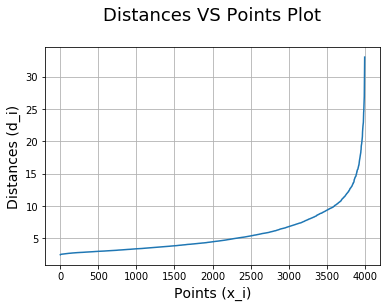

In [183]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 10 because after that there is sharp rise in the value of distances (d_i's)

In [184]:
optimal_eps = 10
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 11
db2 = dbscan(11, min_points, data)


# Clustering with epsilon = 12
db3 = dbscan(12, min_points, data)


# Clustering with epsilon = 13
db4 = dbscan(13, min_points, data)

Number of clusters for MinPts = 200 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 11.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 12.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 13.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



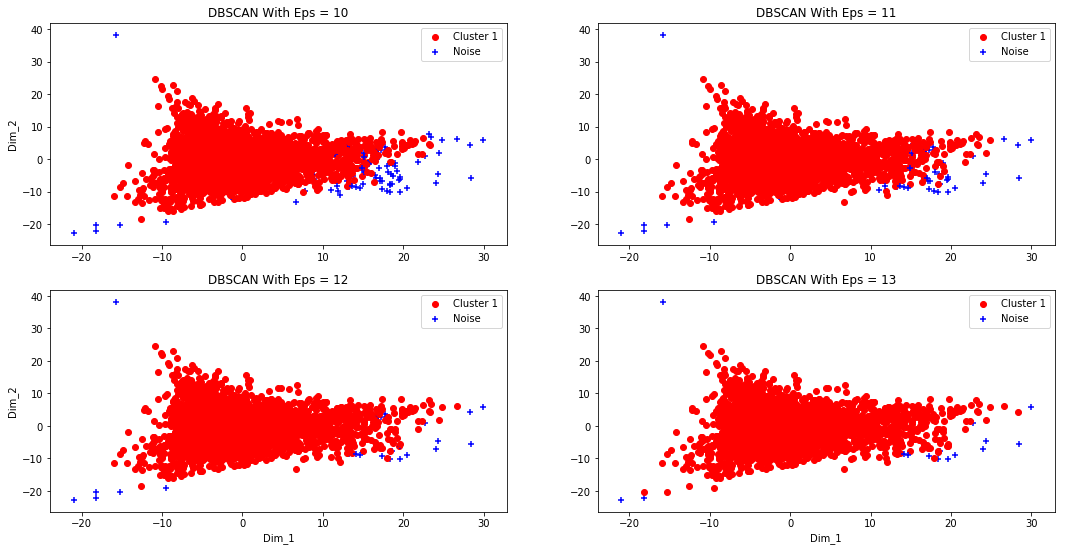

In [185]:
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 10
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 10')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 11
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 11')

# Scatter plot for DBSCAN with Eps = 12
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 12')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 13
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1,c2], ['Cluster 1','Noise'])  
plt.title('DBSCAN With Eps = 13')
plt.xlabel('Dim_1')

plt.show()

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [186]:
# Please write all the code with proper documentation
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=10, min_samples=min_points, n_jobs=-1).fit(data)

reviews = my_final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  3921

No. of reviews in Cluster-2 :  79


In [187]:
# Three Reviews of cluster 1
count=1
m=[]
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        count +=1
m.append(cluster1[0])        

Review-1 : 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college

Review-2 : 
 I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!

Review-3 : 
 Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.



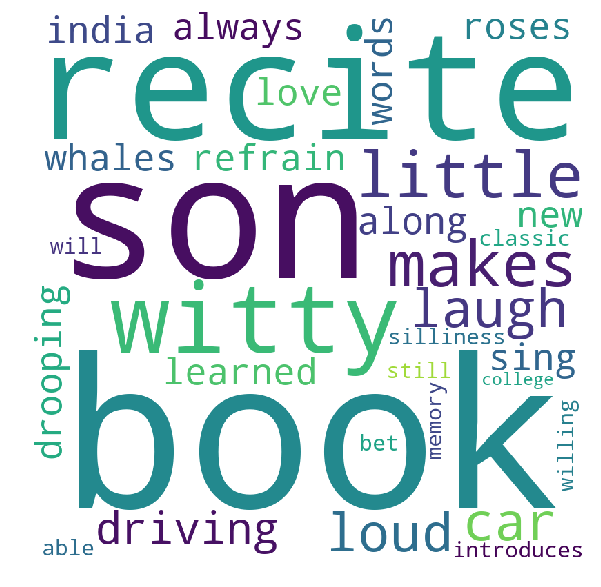

In [188]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [189]:
# Three Reviews of cluster 2
count=1
m=[]
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        count +=1
m.append(cluster2[0])        

Review-1 : 
 Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark, rich roasts.  FYI - the pods are produced in Italy, which is a good sign.  Also, each pod has a handy paper "tab" so that you can remove it from your machine without burning your fingers.  I compared these pods to Starbucks espresso pods (regular and decaf), and the Espressione are my favorite.  Only one warning:  150 pods (individually wrapped) take up a lot of space, so be sure you know where you're going to store them.  More good news:  each box of 150 is stamped with a "best if used by" date, which in my case was 16 months after the date of purchase.

Review-2 : 
 After years of using Starbuck's decaf and regular single serving espresso pods, I finally found a substitute that's more economical and MUCH better tasting.<p>I've used three different brands of pods in my Starbuck'

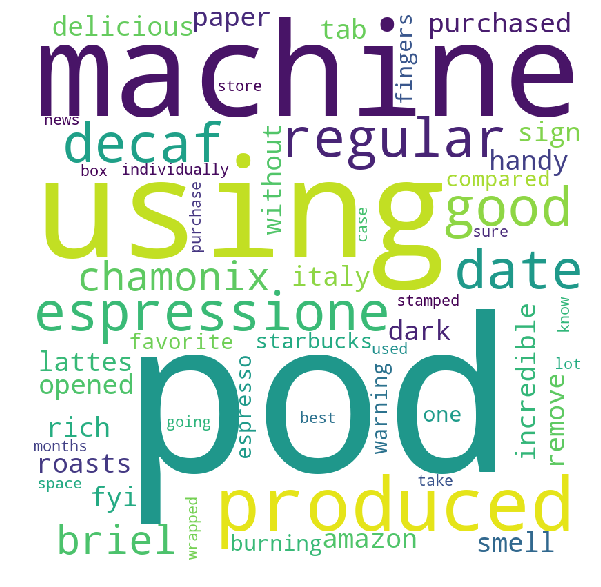

In [190]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in m: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# procedure for k means

* STEP 1 :- Text Preprocessing
* STEP 2 :- Taking all text data and ignoring class variable .
* STEP 3:- Training the vectorizer on text_data and later applying same vectorizer on text_data to transform it into vectors
 bow,tfidf,avgw2v,tfidfw2v 
* STEP 4:- Applying Elbow Method using K-means++ in order to find optimal value of K(i.e. number of clusters)
* STEP 5:- Draw loss VS K-values plot
* STEP 6:- Once we find optimal value of K then again train K-Means++ and K-medoids for clustering text_data into K clusters 
* STEP 7:- Reading reviews manually for each cluster
* STEP 8:- word cloud for cluster

# procedure for agglomerative 

* STEP 1 :- Text Preprocessing
* STEP 2 :- Taking all text data and ignoring class variable .
* STEP 3:- Training the vectorizer on text_data and later applying same vectorizer on text_data to transform it into vectors    avgw2v,tfidfw2v 
* STEP 4:- Implementing Hierarchical Clustering using multiple values of clusters .
* STEP 7:- Reading reviews manually for each cluster
* STEP 8:- word cloud for cluster

# procedure for dbscan

* STEP 1 :- Text Preprocessing
* STEP 2 :- Taking all text data and ignoring class variable .
* STEP 3:- Training the vectorizer on text_data and later applying same vectorizer on text_data to transform it into vectors avgw2v,tfidfw2v 
* STEP 4:- Applying the Elbow Method in order to find the right value of Epsilon
* STEP 5:- Draw distances VS points plot
* STEP 6:- Implementing DBSCAN with various values of Epsilon including the optimal value of Epsilon
* STEP 7:- Reading reviews manually for each cluster
* STEP 8:- word cloud for cluster
* STEP 9:- Draw Scatter plots for DBSCAN with various Epsilon values

# [6] Conclusions

In [193]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['K-means++ for BoW','K-means++ for TFIDF','K-means++ for Avg_Word2Vec','K-means++ for tfidf_Word2Vec']

optimal_k = [bow_means_k,tfidf_means_k,avg_w2v_means_k,tfidf_w2v_means_k]

numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+------------------------------+---------------------+
| S.NO. |            MODEL             | Number of Clusters  |
+-------+------------------------------+---------------------+
|   1   |      K-means++ for BoW       |          3          |
|   2   |     K-means++ for TFIDF      |          3          |
|   3   |  K-means++ for Avg_Word2Vec  |          3          |
|   4   | K-means++ for tfidf_Word2Vec |          3          |
+-------+------------------------------+---------------------+


In [195]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['hierarchichal for Avg_Word2Vec','hierarchichal for tfidf_Word2Vec']

optimal_k = [{2,5,10},{2,5,10}]

numbering = [1,2]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+----------------------------------+---------------------+
| S.NO. |              MODEL               | Number of Clusters  |
+-------+----------------------------------+---------------------+
|   1   |  hierarchichal for Avg_Word2Vec  |      {2, 10, 5}     |
|   2   | hierarchichal for tfidf_Word2Vec |      {2, 10, 5}     |
+-------+----------------------------------+---------------------+


In [194]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ['dbscan for Avg_Word2Vec','dbscan for tfidf_Word2Vec']

optimal_k = [2,2]

numbering = [1,2]

# Initializing prettytable
table = PrettyTable()

# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+---------------------------+---------------------+
| S.NO. |           MODEL           | Number of Clusters  |
+-------+---------------------------+---------------------+
|   1   |  dbscan for Avg_Word2Vec  |          2          |
|   2   | dbscan for tfidf_Word2Vec |          2          |
+-------+---------------------------+---------------------+
